In [9]:
import random
from math import exp
import matplotlib.pyplot as plt
# process data label as 0, 1, 2 for training
def loadDataset(dataset): 
    newdata = []
    for x in range(len(dataset)-1):
        for i in range(0,len(dataset[x]),4):
            if dataset[x][i] == "I": # encounter labels, change it
                if dataset[x][-3:-1] == "sa": # Iris-setosa
                    newdata.append(0)
                elif dataset[x][-2:-1] == "r": # Iris-versicolor
                    newdata.append(1)
                elif dataset[x][-3:-1] == "ca": # Iris-virginica
                    newdata.append(2) 
                break
            else:
                attribute = float(dataset[x][i:i+3])
                newdata.append(attribute)
        trainingSet.append(newdata)       
        newdata = [] # clear the package
    return trainingSet

# find the range of data to do normalize
def dataset_minmax(dataset): # zip a(1,2,3) , b(4,5,6) to [(1,4), (2,5), (3,6)] 
    minmax = list()
    stats = [[min(column), max(column)] for column in zip(*dataset)] # unzip the file
    return stats

# rescale data to range 0~1
def normalize_data(dataset, minmax):
    for row in dataset:
        for i in range(len(row)-1):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

# calculate neuron activation for an input
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation

# transfer neuron activation 
def transfer(activation):
    return 1.0 / (1.0 + exp(-activation))

# calculate the derivative of an neuron output
def transfer_derivative(output):
    return output * (1.0 - output)

#forward propagate input to a network output
def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs # keep updating the neurons
    return inputs

# backpropagate error and sotre in neurons
def backward_propagate_error(network, expected): 
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        if i != len(network)-1:
            for j in range(len(layer)): # hidden
                error = 0.0
                for neuron in network[i+1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error) 
        else:
            for j in range(len(layer)): # output
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

# update network weights with error
def update_weights(network, row, learning_rate):
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += learning_rate * neuron['delta'] * inputs[j]
                neuron['weights'][-1] += learning_rate * neuron['delta']
            
def train_network(network, train, learning_rate, n_epoch, n_outputs):
    print("--------------- lrate=%.3f" % learning_rate ,"-----------------")
    prev_MSE = 0
    MSE = 0
    abs_fraction_of_change = 0
    
    for epoch in range(n_epoch):
        MSE = 0
        sum_error = 0
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
            expected[row[-1]] = 1 # one hot encoding !!!
            backward_propagate_error(network, expected)
            update_weights(network, row, learning_rate)
            update_outputs = forward_propagate(network, row) # update forward results
            MSE += sum([(expected[i] - update_outputs[i])**2 for i in range(len(expected))])
            #print(MSE)
        MSE /= len(expected)
        if epoch > 0:
            abs_fraction_of_change = abs((MSE - prev_MSE) / prev_MSE )
            if abs_fraction_of_change <= 10e-5:
                print("Epoch need:%d"%(epoch))
                break
        print('>epoch=%d, MSE=%.3f, abs fraction of change=%.6f' % (epoch, MSE, abs_fraction_of_change))
        #print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, learning_rate, sum_error))
        prev_MSE = MSE
        #print("prev",prev_MSE)
    return (epoch+1)
   

def init_network(n_inputs, n_hidden, n_outputs): 
# create n_hidden neurons and each neuron in the hidden layer has n_inputs + 1 weights
    network = list() 
    hidden_layer1 = [{'weights': [(random.random()-0.5)/5.0 for i in range(n_inputs + 1)]} for i in range(n_hidden)]
    network.append(hidden_layer1) 
    hidden_layer2 = [{'weights': [(random.random()-0.5)/5.0 for i in range(n_inputs + 1)]} for i in range(n_hidden)]
    network.append(hidden_layer2)
    output_layer = [{'weights': [(random.random()-0.5)/5.0  for i in range(n_hidden + 1)]} for i in range(n_outputs)]
    network.append(output_layer) 
    return network

# make a prediction with a network
# It returns the index in the network output that has the largest probability. 
# Assuming that class values have been converted to integers starting at 0. [0,1,2]
def predict(network, row):
    outputs = forward_propagate(network, row)
    #print(outputs)
    return outputs.index(max(outputs))

# backpropagation with stochastic gradient descent
def back_propagate(train, learning_rate, n_epoch, n_hidden):
    n_inputs = len(train[0]) - 1
    n_outputs = len(set([row[-1] for row in train]))
    network = init_network(n_inputs, n_hidden, n_outputs)
    epoch = train_network(network, train, learning_rate, n_epoch, n_outputs)
    return epoch
    

In [10]:
trainingSet=[]
testSet=[]
results = []
f = open('iris.data.txt', "r")
lines = f.readlines()
dataset = list(lines)
trainingSet = loadDataset(dataset)

In [11]:
# normalize inputs

minmax = dataset_minmax(trainingSet)
normalize_data(trainingSet, minmax)

learning_rate = 0.1
n_epoch = 700
n_hidden = 4
scores = list()
epoch = back_propagate(trainingSet, learning_rate, n_epoch, n_hidden)
results.append(epoch)


--------------- lrate=0.100 -----------------
>epoch=0, MSE=23.507, abs fraction of change=0.000000
>epoch=1, MSE=27.296, abs fraction of change=0.161181
>epoch=2, MSE=27.654, abs fraction of change=0.013118
>epoch=3, MSE=27.689, abs fraction of change=0.001287
>epoch=4, MSE=27.705, abs fraction of change=0.000578
>epoch=5, MSE=27.720, abs fraction of change=0.000531
>epoch=6, MSE=27.735, abs fraction of change=0.000524
>epoch=7, MSE=27.749, abs fraction of change=0.000519
>epoch=8, MSE=27.763, abs fraction of change=0.000514
>epoch=9, MSE=27.777, abs fraction of change=0.000509
>epoch=10, MSE=27.791, abs fraction of change=0.000504
>epoch=11, MSE=27.805, abs fraction of change=0.000499
>epoch=12, MSE=27.819, abs fraction of change=0.000494
>epoch=13, MSE=27.832, abs fraction of change=0.000489
>epoch=14, MSE=27.846, abs fraction of change=0.000484
>epoch=15, MSE=27.859, abs fraction of change=0.000479
>epoch=16, MSE=27.873, abs fraction of change=0.000474
>epoch=17, MSE=27.886, abs fr

In [12]:
# normalize inputs
dataset = list(lines)
trainingSet = loadDataset(dataset) #reload data
minmax = dataset_minmax(trainingSet)
normalize_data(trainingSet, minmax)

learning_rate = 0.2
n_epoch = 300
n_hidden = 4

epoch = back_propagate(trainingSet, learning_rate, n_epoch, n_hidden)
results.append(epoch)

--------------- lrate=0.200 -----------------
>epoch=0, MSE=39.847, abs fraction of change=0.000000
>epoch=1, MSE=44.854, abs fraction of change=0.125646
>epoch=2, MSE=45.040, abs fraction of change=0.004146
>epoch=3, MSE=45.217, abs fraction of change=0.003940
>epoch=4, MSE=45.388, abs fraction of change=0.003779
>epoch=5, MSE=45.552, abs fraction of change=0.003609
>epoch=6, MSE=45.708, abs fraction of change=0.003433
>epoch=7, MSE=45.857, abs fraction of change=0.003256
>epoch=8, MSE=45.998, abs fraction of change=0.003079
>epoch=9, MSE=46.132, abs fraction of change=0.002906
>epoch=10, MSE=46.258, abs fraction of change=0.002738
>epoch=11, MSE=46.378, abs fraction of change=0.002577
>epoch=12, MSE=46.490, abs fraction of change=0.002423
>epoch=13, MSE=46.596, abs fraction of change=0.002277
>epoch=14, MSE=46.695, abs fraction of change=0.002138
>epoch=15, MSE=46.789, abs fraction of change=0.002006
>epoch=16, MSE=46.877, abs fraction of change=0.001881
>epoch=17, MSE=46.960, abs fr

In [13]:
# normalize inputs
trainingSet = loadDataset(dataset) #reload data
minmax = dataset_minmax(trainingSet)
normalize_data(trainingSet, minmax)

learning_rate = 0.3
n_epoch = 300
n_hidden = 4

epoch = back_propagate(trainingSet, learning_rate, n_epoch, n_hidden)
results.append(epoch)

--------------- lrate=0.300 -----------------
>epoch=0, MSE=53.225, abs fraction of change=0.000000
>epoch=1, MSE=58.620, abs fraction of change=0.101367
>epoch=2, MSE=59.163, abs fraction of change=0.009255
>epoch=3, MSE=59.644, abs fraction of change=0.008132
>epoch=4, MSE=60.063, abs fraction of change=0.007032
>epoch=5, MSE=60.427, abs fraction of change=0.006051
>epoch=6, MSE=60.742, abs fraction of change=0.005214
>epoch=7, MSE=61.014, abs fraction of change=0.004492
>epoch=8, MSE=61.250, abs fraction of change=0.003858
>epoch=9, MSE=61.452, abs fraction of change=0.003305
>epoch=10, MSE=61.626, abs fraction of change=0.002834
>epoch=11, MSE=61.777, abs fraction of change=0.002443
>epoch=12, MSE=61.908, abs fraction of change=0.002122
>epoch=13, MSE=62.023, abs fraction of change=0.001855
>epoch=14, MSE=62.124, abs fraction of change=0.001632
>epoch=15, MSE=62.214, abs fraction of change=0.001442
>epoch=16, MSE=62.293, abs fraction of change=0.001279
>epoch=17, MSE=62.364, abs fr

In [14]:
# normalize inputs
trainingSet = loadDataset(dataset) #reload data
minmax = dataset_minmax(trainingSet)
normalize_data(trainingSet, minmax)

learning_rate = 0.4
n_epoch = 300
n_hidden = 4

epoch = back_propagate(trainingSet, learning_rate, n_epoch, n_hidden)
results.append(epoch)

--------------- lrate=0.400 -----------------
>epoch=0, MSE=64.268, abs fraction of change=0.000000
>epoch=1, MSE=70.126, abs fraction of change=0.091151
>epoch=2, MSE=71.205, abs fraction of change=0.015387
>epoch=3, MSE=72.045, abs fraction of change=0.011791
>epoch=4, MSE=72.685, abs fraction of change=0.008887
>epoch=5, MSE=73.168, abs fraction of change=0.006644
>epoch=6, MSE=73.535, abs fraction of change=0.005009
>epoch=7, MSE=73.818, abs fraction of change=0.003851
>epoch=8, MSE=74.041, abs fraction of change=0.003021
>epoch=9, MSE=74.219, abs fraction of change=0.002409
>epoch=10, MSE=74.364, abs fraction of change=0.001947
>epoch=11, MSE=74.482, abs fraction of change=0.001595
>epoch=12, MSE=74.581, abs fraction of change=0.001324
>epoch=13, MSE=74.664, abs fraction of change=0.001114
>epoch=14, MSE=74.735, abs fraction of change=0.000948
>epoch=15, MSE=74.796, abs fraction of change=0.000816
>epoch=16, MSE=74.849, abs fraction of change=0.000708
>epoch=17, MSE=74.895, abs fr

In [15]:
# normalize inputs
trainingSet = loadDataset(dataset) #reload data
minmax = dataset_minmax(trainingSet)
normalize_data(trainingSet, minmax)

learning_rate = 0.5
n_epoch = 300
n_hidden = 4

epoch = back_propagate(trainingSet, learning_rate, n_epoch, n_hidden)
results.append(epoch)

--------------- lrate=0.500 -----------------
>epoch=0, MSE=73.731, abs fraction of change=0.000000
>epoch=1, MSE=80.325, abs fraction of change=0.089436
>epoch=2, MSE=82.003, abs fraction of change=0.020886
>epoch=3, MSE=83.097, abs fraction of change=0.013343
>epoch=4, MSE=83.805, abs fraction of change=0.008513
>epoch=5, MSE=84.278, abs fraction of change=0.005646
>epoch=6, MSE=84.607, abs fraction of change=0.003908
>epoch=7, MSE=84.845, abs fraction of change=0.002808
>epoch=8, MSE=85.022, abs fraction of change=0.002090
>epoch=9, MSE=85.159, abs fraction of change=0.001604
>epoch=10, MSE=85.266, abs fraction of change=0.001263
>epoch=11, MSE=85.353, abs fraction of change=0.001015
>epoch=12, MSE=85.424, abs fraction of change=0.000831
>epoch=13, MSE=85.483, abs fraction of change=0.000690
>epoch=14, MSE=85.532, abs fraction of change=0.000580
>epoch=15, MSE=85.574, abs fraction of change=0.000494
>epoch=16, MSE=85.611, abs fraction of change=0.000425
>epoch=17, MSE=85.642, abs fr

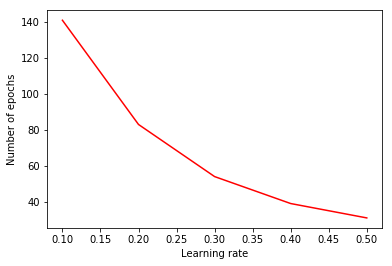

In [16]:
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5], results, 'r')
plt.xlabel("Learning rate")
plt.ylabel("Number of epochs")
plt.show()